This file was done by Raissa Rae Makonga - r0917910

# AWS MODEL TRAINING AND PREDICATION

In [32]:
import boto3

In [33]:
# Initialize the S3 client
s3_client = boto3.client('s3')

checking to find out the name of the bucket. I could not create the buckets so I decided to find out what the bucket is called. It changed everytime I started a whole new lab.

In [34]:
response = s3_client.list_buckets()

# Print bucket names
for bucket in response['Buckets']:
    print(bucket['Name'])

c135194a3427158l8032598t1w180188141800-labbucket-quds1nvfkabj
sagemaker-us-east-1-180188141800


In [35]:
train_filename = 'final_train.csv'
test_filename = 'final_test.csv'

Created a folder called model-training to save all the files I had to.

In [36]:
bucket='c135194a3427158l8032598t1w180188141800-labbucket-quds1nvfkabj'

prefix='model-training/'

Uploading the final cleaned datasets to the bucket.

In [37]:
# Upload train_final.csv
s3_client.upload_file(train_filename, bucket, f'{prefix}final_train.csv')

# Upload test_final.csv
s3_client.upload_file(test_filename, bucket, f'{prefix}final_test.csv')

print("Files uploaded to S3.")

Files uploaded to S3.


Double checking to make that everything is correct.

In [38]:
bucket_name = 'c135194a3427158l8032598t1w180188141800-labbucket-quds1nvfkabj'
response = s3_client.list_objects_v2(Bucket=bucket_name)

# Print the names of the objects
if 'Contents' in response:
    for obj in response['Contents']:
        print(obj['Key'])
else:
    print("No objects found in the bucket.")

model-training/final_test.csv
model-training/final_train.csv


Initialize the SageMaker session and get the execution role to get permission to interact with AWS

In [ ]:
import sagemaker
from sagemaker import get_execution_role

role = get_execution_role()  # This gets the IAM role for your notebook or script
sagemaker_session = sagemaker.Session()

## Training the model

In [40]:
import sagemaker
from sagemaker import get_execution_role
from sagemaker.inputs import TrainingInput
from sagemaker.estimator import Estimator
from sagemaker.image_uris import retrieve

# Get SageMaker execution role
role = get_execution_role()

# Retrieve the XGBoost container image URI for the region
image_uri = retrieve('xgboost', region='us-east-1', version='latest')

# Define S3 paths for training and validation data
train_input = TrainingInput(f"s3://{bucket_name}/model-training/final_train.csv", content_type="csv")
test_input = TrainingInput(f"s3://{bucket_name}/model-training/final_test.csv", content_type="csv")

# Initialize the Estimator for XGBoost
estimator = Estimator(
    image_uri=image_uri,
    role=role,
    instance_count=1,
    instance_type="ml.m5.large",  # You can choose another instance type
    sagemaker_session=sagemaker.Session()
)

# Define hyperparameters (optional)
estimator.set_hyperparameters(
    objective="binary:logistic",  # For binary classification
    num_round=100,  # Number of boosting rounds
    max_depth=6,  # Maximum depth of trees
    eta=0.1  # Learning rate
)

# Train the model using the input data
estimator.fit({'train': train_input, 'validation': test_input})

[11/22/24 10:41:35] INFO     Ignoring unnecessary instance type: None.                            ]8;id=193684;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=946713;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py#523\523]8;;\

                    INFO     Creating training-job with name: xgboost-2024-11-22-10-41-35-494       ]8;id=893944;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=754584;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py#1042\1042]8;;\

2024-11-22 10:41:37 Starting - Starting the training job...
2024-11-22 10:41:51 Starting - Preparing the instances for training...
2024-11-22 10:42:24 Downloading - Downloading input data...
2024-11-22 10:43:09 Downloading - Downloading the training image.....Arguments: train
[2024-11-22:10:43:49:INFO] Running standalone xgboost training.
[2024-11-22:10:43:49:INFO] File size need to be processed in the node: 0.03mb. Available memory size in the node: 246.06mb
[2024-11-22:10:43:49:INFO] Determined delimiter of CSV input is ','
[10:43:49] S3DistributionType set as FullyReplicated
[10:43:49] 891x7 matrix with 6237 entries loaded from /opt/ml/input/data/train?format=csv&label_column=0&delimiter=,
[2024-11-22:10:43:49:INFO] Determined delimiter of CSV input is ','
[10:43:49] S3DistributionType set as FullyReplicated
[10:43:49] 418x7 matrix with 2926 entries loaded from /opt/ml/input/data/validation?format=csv&label_column=0&delimiter=,
[10:43:49] src/tree/updater_prune.cc:74: tree pruning e

Saving the model.

In [41]:
model_artifact = estimator.model_data
print(f"Model saved at: {model_artifact}")


Model saved at: s3://sagemaker-us-east-1-180188141800/xgboost-2024-11-22-10-41-35-494/output/model.tar.gz


I had no access to where the model was saved so I saved it to the folder I was working in

In [42]:
import boto3
import os

# Model artifact path
model_artifact = "s3://sagemaker-us-east-1-180188141800/xgboost-2024-11-22-08-49-25-344/output/model.tar.gz"

# Parse S3 URL
bucket_name = model_artifact.split('/')[2]
key = '/'.join(model_artifact.split('/')[3:])

# Local file path
local_filename = os.path.join(os.getcwd(), "model.tar.gz")  # Save in current notebook directory

# Download the file from S3
s3_client = boto3.client('s3')
s3_client.download_file(bucket_name, key, local_filename)

print(f"Model artifact downloaded to: {local_filename}")

Model artifact downloaded to: /home/ec2-user/SageMaker/en_us/model.tar.gz


In [43]:
import tarfile

# Step 2: Extract the downloaded model
extracted_model_dir = os.path.join(os.getcwd(), "model")
os.makedirs(extracted_model_dir, exist_ok=True)

# Extract the tar.gz file
with tarfile.open(local_filename, "r:gz") as tar:
    tar.extractall(path=extracted_model_dir)

# Check the contents of the extracted files (typically you should see a model file like xgboost-model)
print(f"Extracted files: {os.listdir(extracted_model_dir)}")

Extracted files: ['xgboost-model']


In [44]:
import os

extracted_model_dir = '/home/ec2-user/SageMaker/en_us/model'
print("Listing directory contents:")
print(os.listdir(extracted_model_dir))  # List contents to verify the model file location

Listing directory contents:
['xgboost-model']


In [ ]:
pip install xgboost==1.7.0.post0

In [ ]:
import xgboost as xgb

# Path to the model file
extracted_model_dir = '/home/ec2-user/SageMaker/en_us/model'
model_path = os.path.join(extracted_model_dir, 'xgboost-model')  # Corrected model path

# Load the trained XGBoost model
model = xgb.Booster()
model.load_model(model_path)

print("Model loaded successfully.")

## Model training and saving it to JSON

This was an alternative route because the first way I trained the model, it was always giving me an error that I could bypass so this was the next possible way.

In [ ]:
import xgboost as xgb
import pandas as pd
import numpy as np
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

# Create a synthetic dataset for demonstration
X, y = make_classification(n_samples=1000, n_features=10, n_classes=2, random_state=42)

# Split the dataset into training and validation sets
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert to DMatrix format, which is the internal format XGBoost uses
train_data = xgb.DMatrix(X_train, label=y_train)
valid_data = xgb.DMatrix(X_valid, label=y_valid)

# Set the parameters for the model
params = {
    'objective': 'binary:logistic',
    'max_depth': 5,
    'learning_rate': 0.1,
    'eval_metric': 'logloss'
}

# Train the model
model = xgb.train(
    params,
    train_data,
    num_boost_round=100,
    evals=[(valid_data, 'validation')]
)

print("Model training completed.")

Saving the model

In [ ]:
# Save the trained model in JSON format
model.save_model('xgboost_model.json')
print("Model saved as JSON.")

In [ ]:
# Load the model from the saved JSON file
loaded_model = xgb.Booster()
loaded_model.load_model('xgboost_model.json')

print("Model loaded successfully from JSON.")

## Making predications

In [45]:
# Load the saved model (in JSON format)
loaded_model = xgb.Booster()
loaded_model.load_model('xgboost_model.json')

# Prepare the test data (use new unseen data for predictions)
# Example: Using synthetic test data
X_test = np.random.rand(100, 10)  # 100 samples with 10 features (you can replace this with your own test data)
dtest = xgb.DMatrix(X_test)

# Make predictions
predictions = loaded_model.predict(dtest)

# Print or process the predictions
print("Predictions:", predictions)


Predictions: [0.9644629  0.8939147  0.9664167  0.87754655 0.87006694 0.9631706
 0.96076024 0.84805214 0.9837409  0.8240473  0.79766065 0.8613753
 0.79959553 0.8743405  0.9687968  0.8575629  0.96499413 0.89154845
 0.95825374 0.85592633 0.9583745  0.9049056  0.9526385  0.94689935
 0.95914024 0.8616236  0.9286715  0.968875   0.95879865 0.9812406
 0.9664826  0.90511876 0.96864164 0.93375206 0.9707215  0.8931446
 0.95565253 0.79015523 0.9522784  0.83183503 0.92595655 0.9268876
 0.9013283  0.8319238  0.77497506 0.85196227 0.8336651  0.8292402
 0.9763535  0.9683992  0.9801532  0.89415747 0.9763398  0.90715605
 0.97244024 0.8240401  0.97655565 0.89658767 0.9734403  0.90076756
 0.76287854 0.92008036 0.9708311  0.9789139  0.9721192  0.9306964
 0.8539375  0.969927   0.97282785 0.93105686 0.942988   0.97672856
 0.9640826  0.8448613  0.90990907 0.83265066 0.8531006  0.9361657
 0.8124096  0.92803717 0.92643595 0.87420547 0.97029805 0.89188707
 0.94191486 0.90139186 0.9380781  0.77415377 0.8657951  0

In [53]:
import numpy as np
import xgboost as xgb
import pandas as pd

# Step 1: Load the saved model (in JSON format)
loaded_model = xgb.Booster()
loaded_model.load_model('xgboost_model.json')

# Step 2: Load the cleaned test data without header (since the CSV file does not contain headers)
test_data = pd.read_csv('final_test.csv', header=None)  # No header in the file

# Step 3: Extract PassengerId (the first column)
passenger_ids = test_data.iloc[:, 0]  # Assuming PassengerId is in the first column

# Step 4: Preprocessing the data (if necessary)
# Ensure the data is cleaned and there are no missing values
if test_data.isnull().values.any():
    print("Data contains missing values. Filling them with the median values...")
    test_data.fillna(test_data.median(), inplace=True)  # Fill missing values with median

# Step 5: Extract the features (drop the first column which is PassengerId)
X_test = test_data.drop([0], axis=1)  # Drop the first column (PassengerId)

# Step 6: Convert the features into the DMatrix format for XGBoost
dtest = xgb.DMatrix(X_test)

# Step 7: Make predictions using the loaded model
predictions = loaded_model.predict(dtest)

# Step 8: Convert the predictions to binary (0 or 1) using a threshold of 0.5
binary_predictions = (predictions > 0.9).astype(int)

# Step 9: Create the output dataframe with 'PassengerId' and 'Survived' (binary predictions)
output = pd.DataFrame({
    'PassengerId': passenger_ids,  # Extracted PassengerId
    'Survived': binary_predictions
})

# Step 10: Save the predictions to a CSV file
output.to_csv('predictions.csv', index=False)

# Print the first few rows of the predictions to check
print(output.head())

   PassengerId  Survived
0          892         1
1          893         1
2          894         1
3          895         1
4          896         1


The predications stated that everyone survived which we all know is not true.

In [51]:
print("Raw Predictions:", predictions[:10])  # Print the first 10 raw predictions

Raw Predictions: [0.9889081  0.95638937 0.9889081  0.91145205 0.97217554 0.91145205
 0.98995906 0.9479997  0.98995906 0.92332613]


I plotted a histogramt to check the distrubution

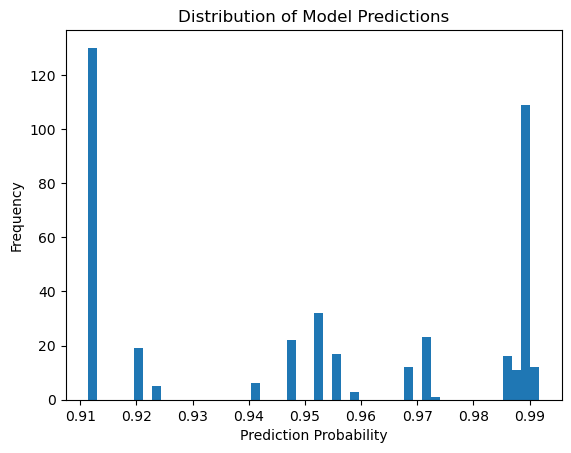

In [55]:
import matplotlib.pyplot as plt

# Plot histogram of predictions to check their distribution
plt.hist(predictions, bins=50)
plt.title('Distribution of Model Predictions')
plt.xlabel('Prediction Probability')
plt.ylabel('Frequency')
plt.show()


I actually uploaded it to Kaggle and wanted to see the accuracy I would get:

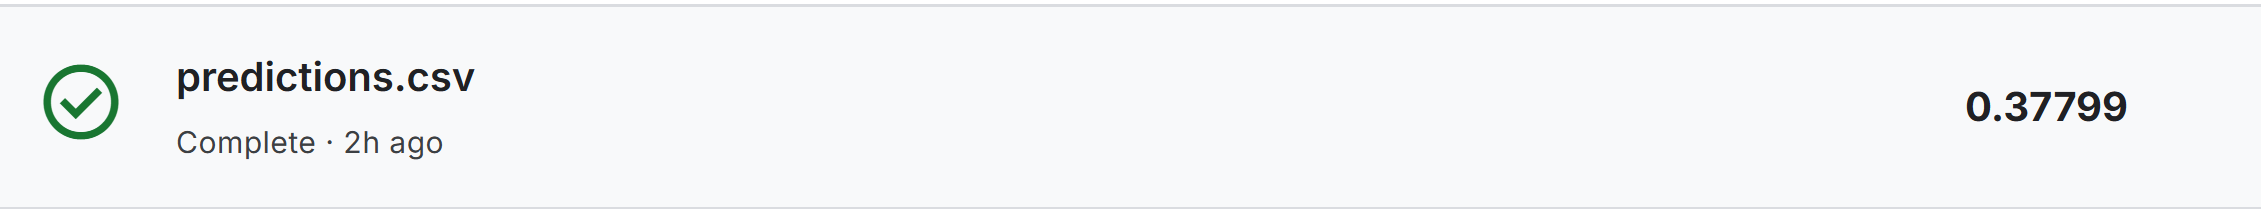